In [1]:
# imports
from tueplots import bundles
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import isfile



In [90]:
plt.rcParams.update(bundles.neurips2022(usetex=False))

In [2]:
# Constants
ENTITY = "ima-vae"
PROJECT = "priors"
SWEEP_ID = "z5hrto4y"


In [9]:
api = wandb.Api(timeout=200)
runs = api.runs(ENTITY + "/" + PROJECT)

sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
sweep_runs = sweep.runs

In [40]:
data = []
filename = f"moebius_sweep_data_{SWEEP_ID}.csv"
max_dim = -1
if not isfile(filename):
    for run in sweep_runs:

        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files
        summary = run.summary._json_dict

        if "epoch" in summary.keys() and summary["epoch"] >=180:
                #or (run.state == 'finished' or ('decoder_var' in run.config.keys() and run.config['decoder_var']>= 0.1)) and f'Metrics/val/latent_statistics.latent_variance_0' in run.history().keys():

            # .config contains the hyperparameters.
            #  We remove special values that start with _.
            config = {k: v for k,v in run.config.items()
                 if not k.startswith('_')}

            dim = config['latent_dim']
            sigmas = run.history(keys=[f'Metrics/val/latent_statistics.latent_variance_{i}' for i in range(dim)]).iloc[-1].to_numpy()[1:]
            col_norms_sq = [run.summary._json_dict[f"Metrics/val/col_norm_{i}"]**2 for i in range(dim)]

            mcc = summary['Metrics/val/mcc']
            mcc_history = run.history(keys=[f'Metrics/val/mcc'])
            max_mcc_step, max_mcc = mcc_history.max()


            cima = summary['Metrics/val/cima']
            cima_history = run.history(keys=[f'Metrics/val/cima'])
            min_cima_step, min_cima = cima_history.min()

            mcc4min_cima = mcc_history[mcc_history._step == int(min_cima_step)]['Metrics/val/mcc'][0]
            cima4max_mcc = cima_history[cima_history._step == int(max_mcc_step)]['Metrics/val/cima'].tolist()[0]

            gamma_square = 1. / config['decoder_var']
            prior = config['model.prior']

            neg_elbo = summary['Metrics/val/neg_elbo']
            neg_elbo_history = run.history(keys=[f'Metrics/val/neg_elbo'])
            min_neg_elbo_step, min_neg_elbo = neg_elbo_history.min()

            mcc4min_neg_elbo = mcc_history[mcc_history._step == int(min_neg_elbo_step)]['Metrics/val/mcc'][0]
            cima4min_neg_elbo = cima_history[cima_history._step == int(min_neg_elbo_step)]['Metrics/val/cima'][0]

            rec_loss = summary['Metrics/val/rec_loss']
            kl_loss = summary['Metrics/val/kl_loss']
            rhs = (1./(float(prior=="gaussian")+gamma_square*np.array(col_norms_sq)))
            if dim > max_dim:
                max_dim = dim

            data.append([run.name, dim, gamma_square, neg_elbo, kl_loss, rec_loss, prior, cima, mcc, min_cima, min_cima_step, cima4max_mcc, cima4min_neg_elbo,
                         max_mcc, max_mcc_step, mcc4min_cima, mcc4min_neg_elbo,  *sigmas, *col_norms_sq, *rhs])


    runs_df = pd.DataFrame(data, columns=["name", "dim", "gamma_square", "neg_elbo", "kl_loss", "rec_loss", "prior", "cima", "mcc", "min_cima", "min_cima_step",  "cima4max_mcc", "cima4min_neg_elbo", "max_mcc", "max_mcc_step",  "mcc4min_cima", "mcc4min_neg_elbo", *[f"sigma_{i}" for i in range(max_dim)],
                                          *[f"col_norm_sq_{i}" for i in range(max_dim)], *[f"rhs_{i}" for i in range(max_dim)]  ] ).fillna(0)
    # runs_df.to_csv(filename)
else:
    runs_df = pd.read_csv(filename)

In [11]:
runs_df

,name,dim,gamma_square,neg_elbo,kl_loss,rec_loss,prior,cima,mcc,min_cima,...,max_mcc_step,sigma_0,sigma_1,sigma_2,col_norm_sq_0,col_norm_sq_1,col_norm_sq_2,rhs_0,rhs_1,rhs_2
0,expert-sweep-152,3,100000.0,-4.262056,-8.310398,12.572454,gaussian,0.000333,0.810733,0.000333,...,298.0,0.000240,0.000228,0.000125,0.041121,0.044720,0.078998,0.000243,0.000224,0.000127
1,gallant-sweep-150,3,100000.0,-4.028031,-8.300945,12.328976,gaussian,0.000258,0.746721,0.000102,...,298.0,0.000298,0.000108,0.000144,0.033667,0.091679,0.069080,0.000297,0.000109,0.000145
2,fast-sweep-149,3,100000.0,-4.463527,-8.299323,12.762849,gaussian,0.000349,0.770626,0.000237,...,268.0,0.000310,0.000185,0.000128,0.032397,0.053954,0.077873,0.000309,0.000185,0.000128
3,lyric-sweep-148,3,100000.0,-4.029673,-8.288069,12.317741,gaussian,0.000033,0.753730,0.000015,...,268.0,0.000106,0.000173,0.000220,0.094582,0.059747,0.045615,0.000106,0.000167,0.000219
4,daily-sweep-147,3,100000.0,-4.582985,-8.282249,12.865234,gaussian,0.000034,0.846394,0.000034,...,274.0,0.000120,0.000239,0.000138,0.083022,0.042135,0.072014,0.000120,0.000237,0.000139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,icy-sweep-21,3,10000000.0,2.854864,-19.496193,16.641328,gaussian,0.181296,0.660679,0.181296,...,250.0,0.000001,0.000003,0.000001,0.082229,0.031206,0.091377,0.000001,0.000003,0.000001
113,eager-sweep-20,3,10000000.0,0.150864,-18.791946,18.641080,gaussian,0.070250,0.955443,0.013581,...,250.0,0.000001,0.000003,0.000001,0.097097,0.034967,0.080638,0.000001,0.000003,0.000001
114,vocal-sweep-19,3,1000000.0,0.267476,-14.809995,14.542519,gaussian,0.008929,0.691305,0.008929,...,250.0,0.000015,0.000015,0.000015,0.064468,0.068604,0.068598,0.000016,0.000015,0.000015
115,dandy-sweep-18,3,1000000.0,-1.652508,-13.933839,15.586348,gaussian,0.006254,0.861100,0.005839,...,256.0,0.000021,0.000021,0.000036,0.047117,0.048213,0.027143,0.000021,0.000021,0.000037


$$ \sigma_k^2 (x) = \left(-n''(\mu_k^\phi(x)) + \gamma^2 \left\Vert \left[ J_f(g(x))\right]_{:k}\right\Vert^2\right)^{-1} $$

In [12]:
runs_df[[ "mcc", "gamma_square"]].groupby("gamma_square").describe()

mcc                                                    \
             count      mean       std       min       25%       50%   
gamma_square                                                           
1.000000e+01  15.0  0.054041  0.002430  0.050564  0.051917  0.055263   
1.000000e+03  18.0  0.647046  0.072981  0.537665  0.566262  0.664681   
1.000000e+04  19.0  0.804843  0.095352  0.660606  0.738997  0.779223   
1.000000e+05  18.0  0.825750  0.082247  0.685043  0.756259  0.830059   
1.000000e+06   6.0  0.826675  0.111241  0.691305  0.734265  0.858621   
1.000000e+07   6.0  0.826864  0.098665  0.660679  0.808616  0.826010   
1.000000e+08  16.0  0.819028  0.090377  0.652155  0.741988  0.822460   
1.000000e+10  19.0  0.819243  0.090641  0.652677  0.754926  0.829415   

                                  
                   75%       max  
gamma_square                      
1.000000e+01  0.055870  0.058308  
1.000000e+03  0.711212  0.737700  
1.000000e+04  0.874560  0.951662  
1.000000e+05  0.890462  0.957422  
1.000000e+06  0.883496  0.966902  
1.000000e+07  0.874168  0.955443  
1.000000e+08  0.872135  0.959077  
1.000000e+10  0.875712  0.947915

In [13]:
runs_df[[ "max_mcc", "gamma_square"]].groupby("gamma_square").describe()

max_mcc                                                    \
               count      mean       std       min       25%       50%   
gamma_square                                                             
1.000000e+01    15.0  0.060406  0.002149  0.057550  0.058835  0.060396   
1.000000e+03    18.0  0.677919  0.067716  0.563657  0.614365  0.703588   
1.000000e+04    19.0  0.814700  0.093300  0.663129  0.754368  0.794485   
1.000000e+05    18.0  0.830349  0.080439  0.690243  0.761707  0.839168   
1.000000e+06     6.0  0.826876  0.111115  0.692047  0.734265  0.858621   
1.000000e+07     6.0  0.826864  0.098665  0.660679  0.808616  0.826010   
1.000000e+08    16.0  0.820706  0.090445  0.652155  0.741988  0.824703   
1.000000e+10    19.0  0.820824  0.090378  0.652677  0.754926  0.829415   

                                  
                   75%       max  
gamma_square                      
1.000000e+01  0.061533  0.065015  
1.000000e+03  0.732770  0.754540  
1.000000e+04  0.886120  0.952010  
1.000000e+05  0.890668  0.957422  
1.000000e+06  0.883842  0.966902  
1.000000e+07  0.874168  0.955443  
1.000000e+08  0.880229  0.959077  
1.000000e+10  0.881275  0.947915

In [14]:
runs_df[[ "cima", "gamma_square"]].groupby("gamma_square").describe()

cima                                                    \
             count      mean       std       min       25%       50%   
gamma_square                                                           
1.000000e+01  15.0  1.663346  0.609784  0.644123  1.400137  1.767956   
1.000000e+03  18.0  0.002005  0.000750  0.000443  0.001572  0.001977   
1.000000e+04  19.0  0.000448  0.000248  0.000174  0.000270  0.000381   
1.000000e+05  18.0  0.000192  0.000109  0.000033  0.000111  0.000164   
1.000000e+06   6.0  0.014251  0.014462  0.001357  0.006565  0.008214   
1.000000e+07   6.0  0.127075  0.071222  0.046682  0.072553  0.120370   
1.000000e+08  16.0  0.104005  0.071063  0.009688  0.051742  0.085172   
1.000000e+10  19.0  0.107466  0.071843  0.002147  0.050355  0.091960   

                                  
                   75%       max  
gamma_square                      
1.000000e+01  1.947531  2.820522  
1.000000e+03  0.002655  0.002993  
1.000000e+04  0.000523  0.001088  
1.000000e+05  0.000279  0.000369  
1.000000e+06  0.017811  0.040693  
1.000000e+07  0.176291  0.223481  
1.000000e+08  0.158878  0.234161  
1.000000e+10  0.158525  0.238764

In [15]:
runs_df[[ "min_cima", "gamma_square"]].groupby("gamma_square").describe()

min_cima                                                    \
                count      mean       std       min       25%       50%   
gamma_square                                                              
1.000000e+01     15.0  0.218229  0.084039  0.102209  0.162130  0.212316   
1.000000e+03     18.0  0.000458  0.000120  0.000275  0.000392  0.000430   
1.000000e+04     19.0  0.000121  0.000088  0.000028  0.000061  0.000082   
1.000000e+05     18.0  0.000104  0.000093  0.000009  0.000024  0.000088   
1.000000e+06      6.0  0.013039  0.014152  0.001357  0.006254  0.008214   
1.000000e+07      6.0  0.111281  0.090657  0.008590  0.030052  0.120370   
1.000000e+08     16.0  0.092197  0.077650  0.006114  0.021613  0.085172   
1.000000e+10     19.0  0.095294  0.081239  0.002092  0.022257  0.082971   

                                  
                   75%       max  
gamma_square                      
1.000000e+01  0.289337  0.382626  
1.000000e+03  0.000529  0.000707  
1.000000e+04  0.000173  0.000374  
1.000000e+05  0.000147  0.000333  
1.000000e+06  0.012668  0.040693  
1.000000e+07  0.176291  0.223481  
1.000000e+08  0.158571  0.234161  
1.000000e+10  0.158525  0.238764

In [16]:
runs_df[[ "neg_elbo", "gamma_square"]].groupby("gamma_square").describe()

neg_elbo                                                     \
                count         mean          std         min          25%   
gamma_square                                                               
1.000000e+01     15.0    -0.657942     0.000219   -0.658203    -0.658093   
1.000000e+03     18.0    -4.752853     0.015176   -4.771536    -4.764594   
1.000000e+04     19.0    -4.664338     0.103931   -4.789461    -4.748212   
1.000000e+05     18.0    -4.208588     0.360666   -4.607050    -4.459450   
1.000000e+06      6.0    -1.300890     0.844837   -2.225483    -1.655821   
1.000000e+07      6.0     4.516614     5.213138    0.150864     1.745995   
1.000000e+08     16.0    43.571480    47.483703    2.882845     9.965580   
1.000000e+10     19.0  6360.511878  5145.303769  583.680076  1901.246390   

                                                       
                      50%           75%           max  
gamma_square                                           
1.000000e+01    -0.657981     -0.657885     -0.657509  
1.000000e+03    -4.754675     -4.746067     -4.712541  
1.000000e+04    -4.674776     -4.638734     -4.363001  
1.000000e+05    -4.223636     -4.028442     -3.130947  
1.000000e+06    -1.475174     -1.254504      0.267476  
1.000000e+07     2.533263      5.105240     14.436153  
1.000000e+08    27.999539     47.526874    172.432388  
1.000000e+10  5137.261631  10631.301507  15485.804276

In [17]:
runs_df[[ "kl_loss", "gamma_square"]].groupby("gamma_square").describe()

kl_loss                                                        \
               count       mean       std        min        25%        50%   
gamma_square                                                                 
1.000000e+01    15.0  -0.000005  0.000004  -0.000018  -0.000006  -0.000003   
1.000000e+03    18.0  -1.429678  0.007418  -1.441499  -1.434600  -1.430272   
1.000000e+04    19.0  -4.714713  0.011283  -4.739982  -4.723210  -4.713786   
1.000000e+05    18.0  -8.299991  0.014407  -8.322529  -8.310244  -8.300595   
1.000000e+06     6.0 -13.373411  1.036792 -14.809995 -13.897326 -13.396619   
1.000000e+07     6.0 -18.158189  1.030244 -19.496193 -18.662514 -18.184407   
1.000000e+08    16.0 -22.201445  1.240881 -23.780359 -23.029360 -22.487032   
1.000000e+10    19.0 -25.513367  1.869650 -28.409334 -26.644715 -25.906878   

                                    
                    75%        max  
gamma_square                        
1.000000e+01  -0.000002  -0.000001  
1.000000e+03  -1.427014  -1.412164  
1.000000e+04  -4.709321  -4.695731  
1.000000e+05  -8.288499  -8.273837  
1.000000e+06 -12.926591 -11.803092  
1.000000e+07 -17.926364 -16.421896  
1.000000e+08 -21.521556 -20.152971  
1.000000e+10 -24.738610 -21.538273

In [18]:
runs_df[[ "rec_loss", "gamma_square"]].groupby("gamma_square").describe()

rec_loss                                                        \
                count         mean          std           min           25%   
gamma_square                                                                  
1.000000e+01     15.0     0.657947     0.000218      0.657512      0.657889   
1.000000e+03     18.0     6.182531     0.019462      6.136330      6.176445   
1.000000e+04     19.0     9.379051     0.103764      9.076866      9.349495   
1.000000e+05     18.0    12.508579     0.357745     11.440727     12.320550   
1.000000e+06      6.0    14.674301     0.675637     14.028575     14.181094   
1.000000e+07      6.0    13.641575     5.472263      3.434134     12.731983   
1.000000e+08     16.0   -21.370036    47.197201   -148.845965    -25.391186   
1.000000e+10     19.0 -6334.998511  5145.301782 -15459.897403 -10608.206522   

                                                    
                      50%          75%         max  
gamma_square                                        
1.000000e+01     0.657984     0.658099    0.658205  
1.000000e+03     6.186221     6.194778    6.211289  
1.000000e+04     9.383281     9.453645    9.506475  
1.000000e+05    12.530041    12.756389   12.920944  
1.000000e+06    14.422906    15.219162   15.586348  
1.000000e+07    15.425782    16.672914   18.641080  
1.000000e+08    -7.778928    12.656529   20.897511  
1.000000e+10 -5112.068674 -1874.808757 -556.565815

{'bodies': [<matplotlib.collections.PolyCollection at 0x11e3b0910>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x11e3b0790>,
 'cmins': <matplotlib.collections.LineCollection at 0x11e3d9640>,
 'cbars': <matplotlib.collections.LineCollection at 0x11e391df0>}

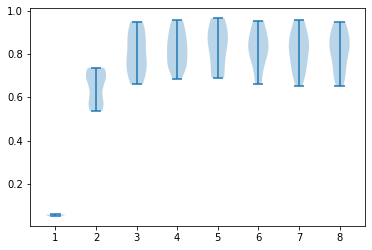

In [19]:
groups = [g.mcc for _, g in runs_df[[ "mcc", "gamma_square"]].groupby("gamma_square")]
plt.violinplot(groups)

{'bodies': [<matplotlib.collections.PolyCollection at 0x11e4d3940>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x11e4d37f0>,
 'cmins': <matplotlib.collections.LineCollection at 0x11e4f1640>,
 'cbars': <matplotlib.collections.LineCollection at 0x11e4f1ac0>}

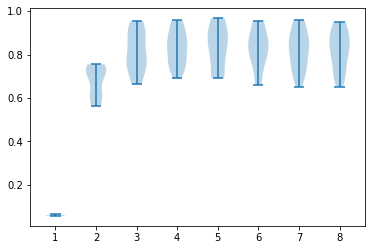

In [20]:
groups = [g.max_mcc for _, g in runs_df[[ "max_mcc", "gamma_square"]].groupby("gamma_square")]
plt.violinplot(groups)

In [22]:
df_rhs = pd.DataFrame(runs_df[[col for col in runs_df.columns if "rhs" in col]].stack().droplevel(1), columns=["rhs"])
df_lhs = pd.DataFrame(runs_df[[col for col in runs_df.columns if "sigma" in col]].stack().droplevel(1), columns=["lhs"])
df_rhs_lhs_gamma_sq = df_rhs.merge( df_lhs, left_index=True, right_index=True).merge(runs_df["gamma_square"], left_index=True, right_index=True)

/var/folders/rb/d8k1n6bj4lg801y0yxz4jtbh0000gn/T/ipykernel_10088/949298632.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0]+ sorted(np.log10(runs_df["gamma_square"]).astype(int).unique()))


Text(0.5, 0, '$\\log_{10}\\gamma^2$')

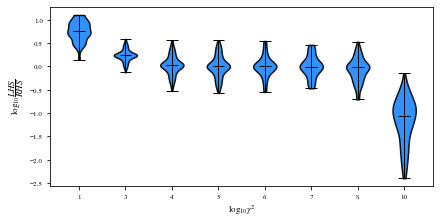

In [91]:
groups = [np.log10((g.rhs/g.lhs).abs()) for _, g in df_rhs_lhs_gamma_sq.groupby("gamma_square")]
fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(111)

vp= plt.violinplot(groups, showmedians=True)
for el in vp['bodies']:
    el.set_facecolor('#1A85FF')
    el.set_edgecolor('black')
    el.set_linewidth(1.5)
    el.set_alpha(.9)
for pn in ['cbars', 'cmins', 'cmaxes', 'cmedians']:
    vp_ = vp[pn]
    vp_.set_edgecolor('black')
    vp_.set_linewidth(1)
ax.set_xticklabels([0]+ sorted(np.log10(runs_df["gamma_square"]).astype(int).unique()))
# plt.locator_params(axis='y', nbins=5)
# plt.yticks(fontsize=24)
# plt.ylim([0, 0.5])
plt.ylabel('$\log_{10}\dfrac{LHS}{RHS}$')
plt.xlabel('$\log_{10}\gamma^2$')

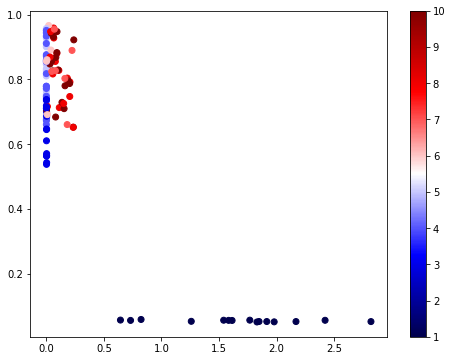

In [38]:
plt.figure(figsize=(8,6))
plt.scatter((runs_df["cima"]), (runs_df[ "mcc"]), c=np.log10(runs_df["gamma_square"]), cmap="seismic")
plt.colorbar()

{'bodies': [<matplotlib.collections.PolyCollection at 0x11f61a8e0>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x11f57c550>,
 'cmins': <matplotlib.collections.LineCollection at 0x11f655ee0>,
 'cbars': <matplotlib.collections.LineCollection at 0x11f6653a0>}

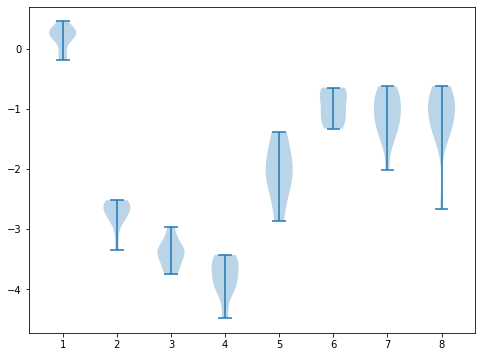

In [37]:
groups = [np.log10(g.cima) for _, g in runs_df[[ "cima", "gamma_square"]].groupby("gamma_square")]
plt.figure(figsize=(8,6))
plt.violinplot(groups)

{'bodies': [<matplotlib.collections.PolyCollection at 0x11e988d30>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x11e988bb0>,
 'cmins': <matplotlib.collections.LineCollection at 0x11e9aaa60>,
 'cbars': <matplotlib.collections.LineCollection at 0x11e9aaee0>}

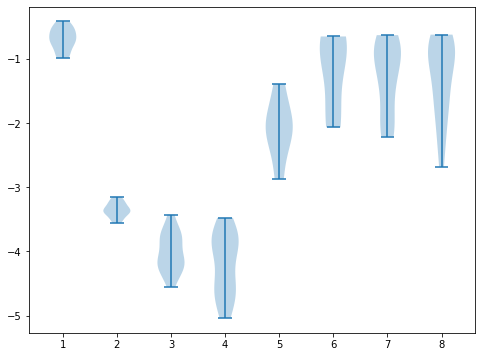

In [31]:
groups = [np.log10(g.min_cima) for _, g in runs_df[[ "min_cima", "gamma_square"]].groupby("gamma_square")]
plt.figure(figsize=(8,6))
plt.violinplot(groups)

{'bodies': [<matplotlib.collections.PolyCollection at 0x11ea17b20>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x11ea179a0>,
 'cmins': <matplotlib.collections.LineCollection at 0x11ea39850>,
 'cbars': <matplotlib.collections.LineCollection at 0x11ea39cd0>}

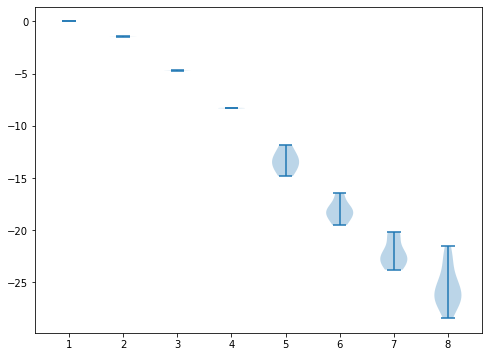

In [32]:
groups = [(g.kl_loss) for _, g in runs_df[[ "kl_loss", "gamma_square"]].groupby("gamma_square")]
plt.figure(figsize=(8,6))
plt.violinplot(groups)

{'bodies': [<matplotlib.collections.PolyCollection at 0x11eaab760>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x11eaab670>,
 'cmins': <matplotlib.collections.LineCollection at 0x11eacc310>,
 'cbars': <matplotlib.collections.LineCollection at 0x11eacc790>}

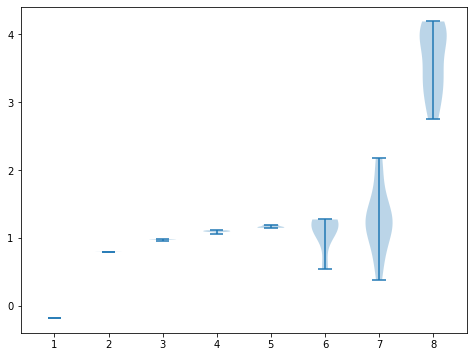

In [33]:
groups = [np.log10(g.rec_loss.abs()) for _, g in runs_df[[ "rec_loss", "gamma_square"]].groupby("gamma_square")]
plt.figure(figsize=(8,6))
plt.violinplot(groups)

{'bodies': [<matplotlib.collections.PolyCollection at 0x11eb3a7c0>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x11eb3a640>,
 'cmins': <matplotlib.collections.LineCollection at 0x11eb594f0>,
 'cbars': <matplotlib.collections.LineCollection at 0x11eb59970>}

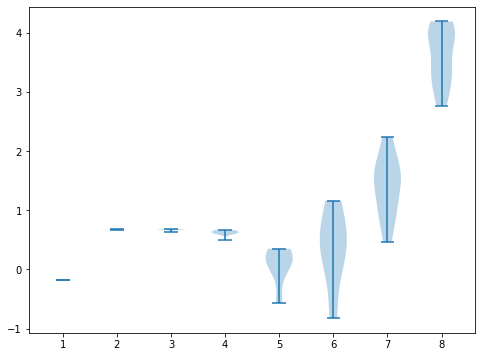

In [34]:
groups = [np.log10(g.neg_elbo.abs()) for _, g in runs_df[[ "neg_elbo", "gamma_square"]].groupby("gamma_square")]
plt.figure(figsize=(8,6))
plt.violinplot(groups)

In [35]:
ext_gamma_sq = [g*np.ones((d, 1)) for g,d in zip(gamma_sq, dim)]

NameError: name 'gamma_sq' is not defined

In [ ]:
def lhs_rhs(col_norm_squared, priors, variances, gamma_squared, ext_gamma_squared, prior_name):
    lhs = [s for s,p in zip(variances,priors) if p == prior_name]
    rhs = [1./(float(prior_name=="gaussian")+g_sq*J_sq) for g_sq, J_sq, p in zip(gamma_squared, col_norm_squared, priors) if p == prior_name]
    gamma = np.array([g for g,p in zip(gamma_squared, priors) if p == prior_name])
    gamma_ext = np.concatenate([g for g,p in zip(ext_gamma_squared, priors) if p == prior_name])

    abs_diff = np.abs(np.concatenate(lhs)-np.concatenate(rhs))
    lhs_rhs_vs_gamma =[ np.array([d for d, g in zip(abs_diff, gamma_ext) if g==gamma_select]) for gamma_select in np.unique(gamma_ext)  ]

    return lhs, rhs, gamma_ext, gamma, abs_diff, lhs_rhs_vs_gamma

In [47]:
lhs_gauss ,rhs_gauss,gamma_gauss_ext,  gamma_gauss, abs_diff_gauss, lhs_rhs_vs_gamma_gauss = lhs_rhs(col_norm_sq, prior, sigmas, gamma_sq, ext_gamma_sq, "gaussian")
lhs_laplace ,rhs_laplace,gamma_laplace_ext, gamma_laplace,  abs_diff_laplace, lhs_rhs_vs_gamma_laplace = lhs_rhs(col_norm_sq, prior, sigmas, gamma_sq,  ext_gamma_sq,"laplace")
lhs_uniform ,rhs_uniform,gamma_uniform_ext, gamma_uniform,  abs_diff_uniform, lhs_rhs_vs_gamma_uniform = lhs_rhs(col_norm_sq, prior, sigmas, gamma_sq,  ext_gamma_sq,"uniform")

In [48]:
def violin_by_prior(gauss_data, laplace_data, uniform_data, xticks, xlabel, ylabel,  offset, filename, figsize=(8,6), log=False):

    plt.figure(figsize=figsize)
    vp_gauss = plt.violinplot([np.log10(i) if log is True else i for i in gauss_data], positions=xticks)
    vp_laplace = plt.violinplot([np.log10(i) if log is True else i for i in laplace_data], positions=-offset+xticks)
    vp_uniform= plt.violinplot([np.log10(i) if log is True else i for i in uniform_data], positions=offset+xticks)
    plt.legend([vp_gauss['bodies'][0],vp_laplace['bodies'][0], vp_uniform['bodies'][0]], ['gaussian', 'laplace', 'uniform'], loc='upper right')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(xticks)
    # plt.tight_layout()
    plt.savefig(filename)

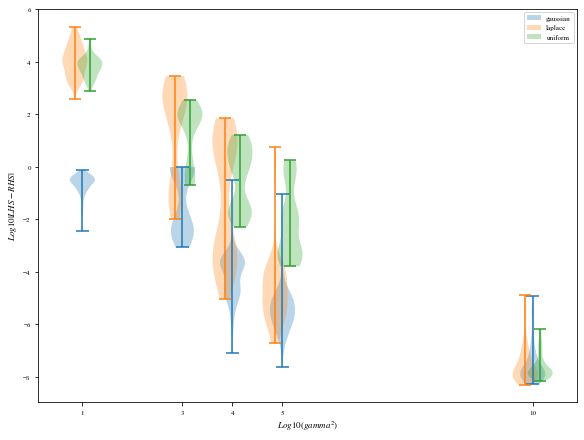

In [49]:
violin_by_prior(lhs_rhs_vs_gamma_gauss, lhs_rhs_vs_gamma_laplace, lhs_rhs_vs_gamma_uniform,  np.unique(np.log10(gamma_uniform_ext)), '$Log10(gamma^2)$', '$Log10|LHS-RHS|$',  0.15, 'opt_sigma_vs_gamma', log=True)

In [50]:
def cima_mcc(cimas, mccs, dims, priors,  prior_name):
    cima = np.array([c for c,p in zip(cimas, priors) if p == prior_name])
    mcc = np.array([m for m,p in zip(mccs, priors) if p == prior_name])
    dim = np.array([d for d,p in zip(dims, priors) if p == prior_name])


    cima_vs_dim = [ np.array([c for d, c in zip(dim, cima) if d==dim_select]) for dim_select in np.unique(dim)  ]
    mcc_vs_dim = [ np.array([m for d, m in zip(dim, mcc) if d==dim_select]) for dim_select in np.unique(dim)  ]

    return cima, mcc, dim, cima_vs_dim, mcc_vs_dim

In [51]:
cima_gauss, mcc_gauss, dim_gauss, cima_vs_dim_gauss, mcc_vs_dim_gauss = cima_mcc(cima, mcc, dim, prior, "gaussian")
cima_laplace, mcc_laplace, dim_laplace, cima_vs_dim_laplace, mcc_vs_dim_laplace = cima_mcc(cima, mcc, dim, prior, "laplace")
cima_uniform, mcc_uniform, dim_uniform, cima_vs_dim_uniform, mcc_vs_dim_uniform = cima_mcc(cima, mcc, dim, prior, "uniform")

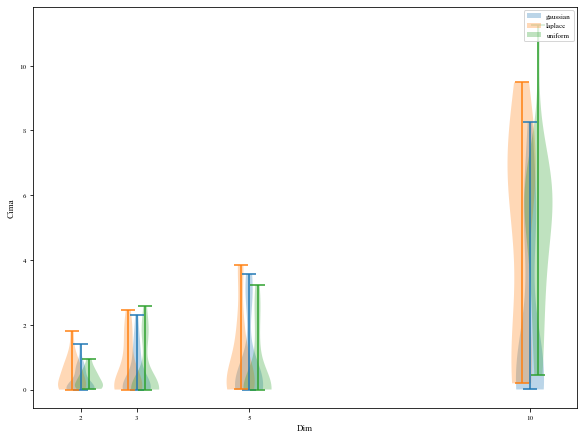

In [32]:
violin_by_prior(cima_vs_dim_gauss, cima_vs_dim_laplace, cima_vs_dim_uniform,  np.unique(dim), 'Dim', 'Cima',  0.15, 'cima_vs_dim')

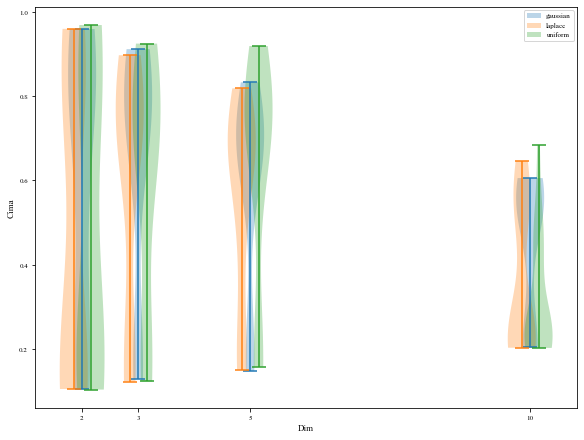

In [33]:
violin_by_prior(mcc_vs_dim_gauss, mcc_vs_dim_laplace, mcc_vs_dim_uniform,  np.unique(dim), 'Dim', 'Cima',  0.15, 'mcc_vs_dim')

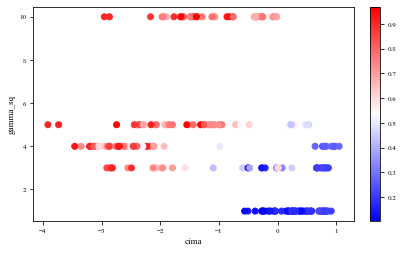

In [34]:
plt.scatter(np.log10(cima), np.log10(gamma_sq),c=mcc,cmap='bwr',)
plt.xlabel('cima')
plt.ylabel('gamma_sq')
plt.colorbar()

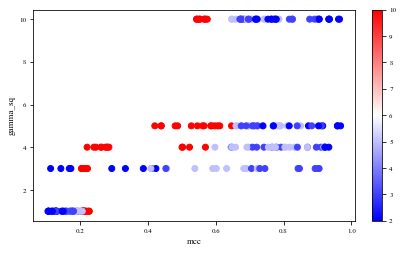

In [35]:
plt.scatter(mcc, np.log10(gamma_sq), c=dim,cmap='bwr',)
plt.xlabel('mcc')
plt.ylabel('gamma_sq')
plt.colorbar()

In [36]:
cima_vs_dim = [ np.array([c for d, c in zip(dim, cima) if d==dim_select]) for dim_select in np.unique(np.array(dim))  ]
mcc_vs_dim = [ np.array([m for d, m in zip(dim, mcc) if d==dim_select]) for dim_select in np.unique(np.array(dim))  ]

{'bodies': [<matplotlib.collections.PolyCollection at 0x1207d5a30>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x12076ec40>,
 'cmins': <matplotlib.collections.LineCollection at 0x124587eb0>,
 'cbars': <matplotlib.collections.LineCollection at 0x124587100>}

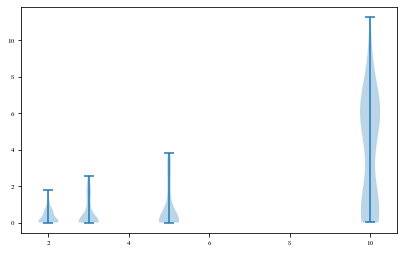

In [37]:
plt.violinplot(cima_vs_dim, positions=np.unique(np.array(dim)))

In [38]:
markers = ['o' if p=="gauss" else '^' if p=='laplace' else 's' for p in prior]

/var/folders/rb/d8k1n6bj4lg801y0yxz4jtbh0000gn/T/ipykernel_55960/2388439361.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/rb/d8k1n6bj4lg801y0yxz4jtbh0000gn/T/ipykernel_55960/2388439361.py:9: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


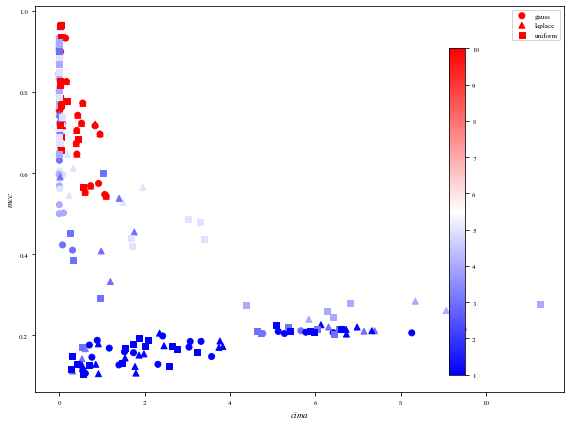

In [39]:
plt.figure(figsize=(8,6))
plt.scatter((cima_gauss),(mcc_gauss), c=np.log10(gamma_gauss),cmap='bwr', marker='o', label='gauss')
plt.scatter((cima_laplace),(mcc_laplace), c=np.log10(gamma_laplace),cmap='bwr', marker='^', label='laplace')
plt.scatter((cima_uniform),(mcc_uniform), c=np.log10(gamma_uniform),cmap='bwr', marker='s', label='uniform')
plt.xlabel("$cima$")
plt.ylabel("$mcc$")
plt.colorbar()
plt.legend()
plt.tight_layout()
plt.savefig('cima_vs_mcc')

In [58]:
gauss_mcc_vs_gamma = [ np.array([m,g]) for (g, m, d) in zip(gamma_gauss, mcc_gauss, dim_gauss) if d == 5]
gauss_mcc_vs_gamma_violin = [ np.array([m for m, g in gauss_mcc_vs_gamma if g==gamma_select]) for gamma_select in np.unique(gamma_gauss)  ]

In [60]:
np.unique(gamma_gauss)

array([1.e+01, 1.e+03, 1.e+04, 1.e+05, 1.e+10])

{'bodies': [<matplotlib.collections.PolyCollection at 0x126617d60>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x126617280>,
 'cmins': <matplotlib.collections.LineCollection at 0x126638b80>,
 'cbars': <matplotlib.collections.LineCollection at 0x1266179a0>}

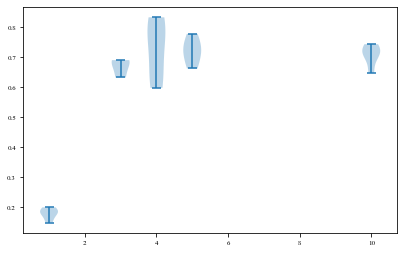

In [61]:
plt.violinplot(gauss_mcc_vs_gamma_violin, positions=np.log10(np.unique(gamma_gauss)))

In [62]:
gauss_cima_vs_gamma = [ np.array([m,g]) for (g, m, d) in zip(gamma_gauss, cima_gauss, dim_gauss) if d == 5]
gauss_cima_vs_gamma_violin = [ np.array([m for m, g in gauss_cima_vs_gamma if g==gamma_select]) for gamma_select in np.unique(gamma_gauss)  ]

{'bodies': [<matplotlib.collections.PolyCollection at 0x126615520>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x126615a60>,
 'cmins': <matplotlib.collections.LineCollection at 0x126626a00>,
 'cbars': <matplotlib.collections.LineCollection at 0x12662d5e0>}

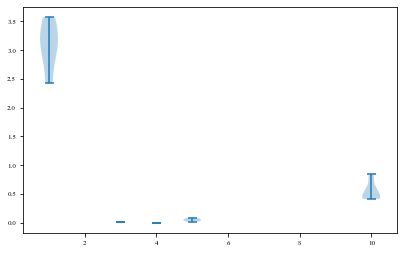

In [63]:
plt.violinplot(gauss_cima_vs_gamma_violin, positions=np.log10(np.unique(gamma_gauss)))